In [1]:
!pip install scikit-learn==0.24.1  aif360==0.3.0  tensorflow==2.4.0 nodejs==0.1.1 ipywidgets==7.6.3 lime==0.2.0.1 import_ipynb==0.1.3 #aix360==0.2.1 

In [ ]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [1]:
import tensorflow as tf
from tensorflow import keras
import import_ipynb
from codait_utils import *

importing Jupyter notebook from codait_utils.ipynb


In [3]:
unzip('.','model.zip')
unzip('.','data.zip')

In [3]:
model = keras.models.load_model('model')

In [4]:
import os.path  
import glob  
folder = glob.glob("data/*")
num_classes=len(folder)

batch_size = 32
img_height = 400
img_width = 400
input_shape = (img_width,img_height)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))


Found 930 files belonging to 25 classes.
Using 744 files for training.
Found 930 files belonging to 25 classes.
Using 186 files for validation.


In [5]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [6]:
val_ds_shuffeled = val_ds.shuffle(1)
for image, label in val_ds:
    break
label = label[0]
print(len(label))
label = tf.reshape(label, [1, len(label)])
print(label)
tf.math.argmax(label,1)
label = tf.math.argmax(label,1).numpy()[0] #de-onehotencode

25
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]], shape=(1, 25), dtype=float32)


In [7]:
def get_random_image():
    val_ds_shuffeled = val_ds.shuffle(1)
    for image, label in val_ds:
        break
    image = image.numpy().astype(int)
    image = image[0]
    label = label[0]
    label = tf.reshape(label, [1, len(label)])
    image = image.reshape(img_height,img_width,3)
    image_for_model = image.reshape(1,img_height,img_width,3)
    label = tf.math.argmax(label,1).numpy()[0] #de-onehotencode
    prediction = model.predict(image_for_model)
    prediction = tf.math.argmax(prediction,1).numpy()[0] #de-onehotencode
    return image, label, prediction

In [11]:
from lime.wrappers.scikit_image import SegmentationAlgorithm


def get_explaination_as_mask(image, label):
    segmentation_fn = SegmentationAlgorithm(algo_type = 'slic')
    explanation = explainer.explain_instance(image, model.predict, segmentation_fn=segmentation_fn)
    print(label)
    return explanation.get_image_and_mask(label)[1]

In [12]:
def merge_image_with_mask(image,mask):
    np_mask = np.array(mask.astype(int)*255,np.uint8)
    np_merged = np.empty(image.shape, np.uint8)
    np_merged[:,:,0] = np.maximum(image[:,:,0],np_mask)
    np_merged[:,:,1] = np.maximum(image[:,:,1],np_mask)
    np_merged[:,:,2] = np.maximum(image[:,:,2],np_mask)
    return np_merged

/opt/conda/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

17


/opt/conda/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

24


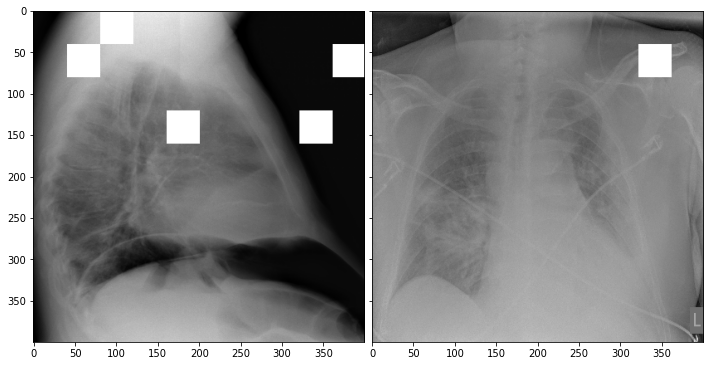

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax in grid:
    image, label, prediction = get_random_image()
    mask = get_explaination_as_mask(image, label)
    masked_image = merge_image_with_mask(image,mask)
    ax.imshow(masked_image)

plt.show()